In [55]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
from collections import Counter
import ast
import re
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer


# Extracción

## 1. Corroborar que las carpetas existan y, de lo contrario, crearlas


In [56]:
#%run scripts/verificar_crear_carpetas.py

## 2. Descargar los archivos si no existen

In [57]:
#%run scripts/descargar_archivos.py

## 3. Descomprimir los archivos

In [58]:
#%run scripts/descomprimir_archivos.py


## 4. Descomprimir los archivos sin errores

In [59]:
#%run scripts/procesar_archivos_gzip.py

## 5. Cargar los archivos en DataFrames y mostrar en formato Markdown


In [60]:
# Especificamos la ruta de los archivos JSON con el prefijo "se"
carpeta = "datasets/original"
archivo1 = os.path.join(carpeta, "se_user_reviews.json")
archivo2 = os.path.join(carpeta, "se_users_items.json")
archivo3 = os.path.join(carpeta, "se_steam_games.json")

# Cargamos los archivos JSON en DataFrames
df_users_reviews = pd.read_json(archivo1, orient='records', lines=True)
df_users_items = pd.read_json(archivo2, orient='records', lines=True)
df_steam_games = pd.read_json(archivo3, orient='records', lines=True)

# Imprimimos los DataFrames en formato Markdown
print("### DataFrame: user_reviews")
print(df_users_reviews.head().to_markdown(index=False))
print("\n### DataFrame: users_items")
print(df_users_items.head().to_markdown(index=False))
print("\n### DataFrame: steam_games")
print(df_steam_games.head().to_markdown(index=False))

### DataFrame: user_reviews
| user_id           | user_url                                             | reviews                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

# TRANSFORMACIÓN

## **`1. EDA steam_games.json`**

### Limpieza y Preprocesamiento de los Datos

1. Identificar valores nulos:

In [61]:
# Calcular el número de valores nulos por columna
nulos_por_columna = df_steam_games.isnull().sum()

# Calcular el porcentaje de valores nulos por columna
porcentaje_nulos = (nulos_por_columna / len(df_steam_games)) * 100

# Crear un DataFrame con los resultados y redondear el porcentaje a un decimal
resultado = pd.DataFrame({
    'Cantidad Nulos': nulos_por_columna,
    'Porcentaje Nulos': porcentaje_nulos.round(1)  # Redondear a un decimal
})

# Mostrar los resultados
print(resultado)

              Cantidad Nulos  Porcentaje Nulos
publisher              96362              80.0
genres                 91593              76.0
app_name               88312              73.3
title                  90360              75.0
url                    88310              73.3
release_date           90377              75.0
tags                   88473              73.5
reviews_url            88312              73.3
specs                  88980              73.9
price                  89687              74.5
early_access           88310              73.3
id                     88312              73.3
developer              91609              76.1


- Niestro dataset contiene muchos valores nulos, vamos a procedera eliminarlos.

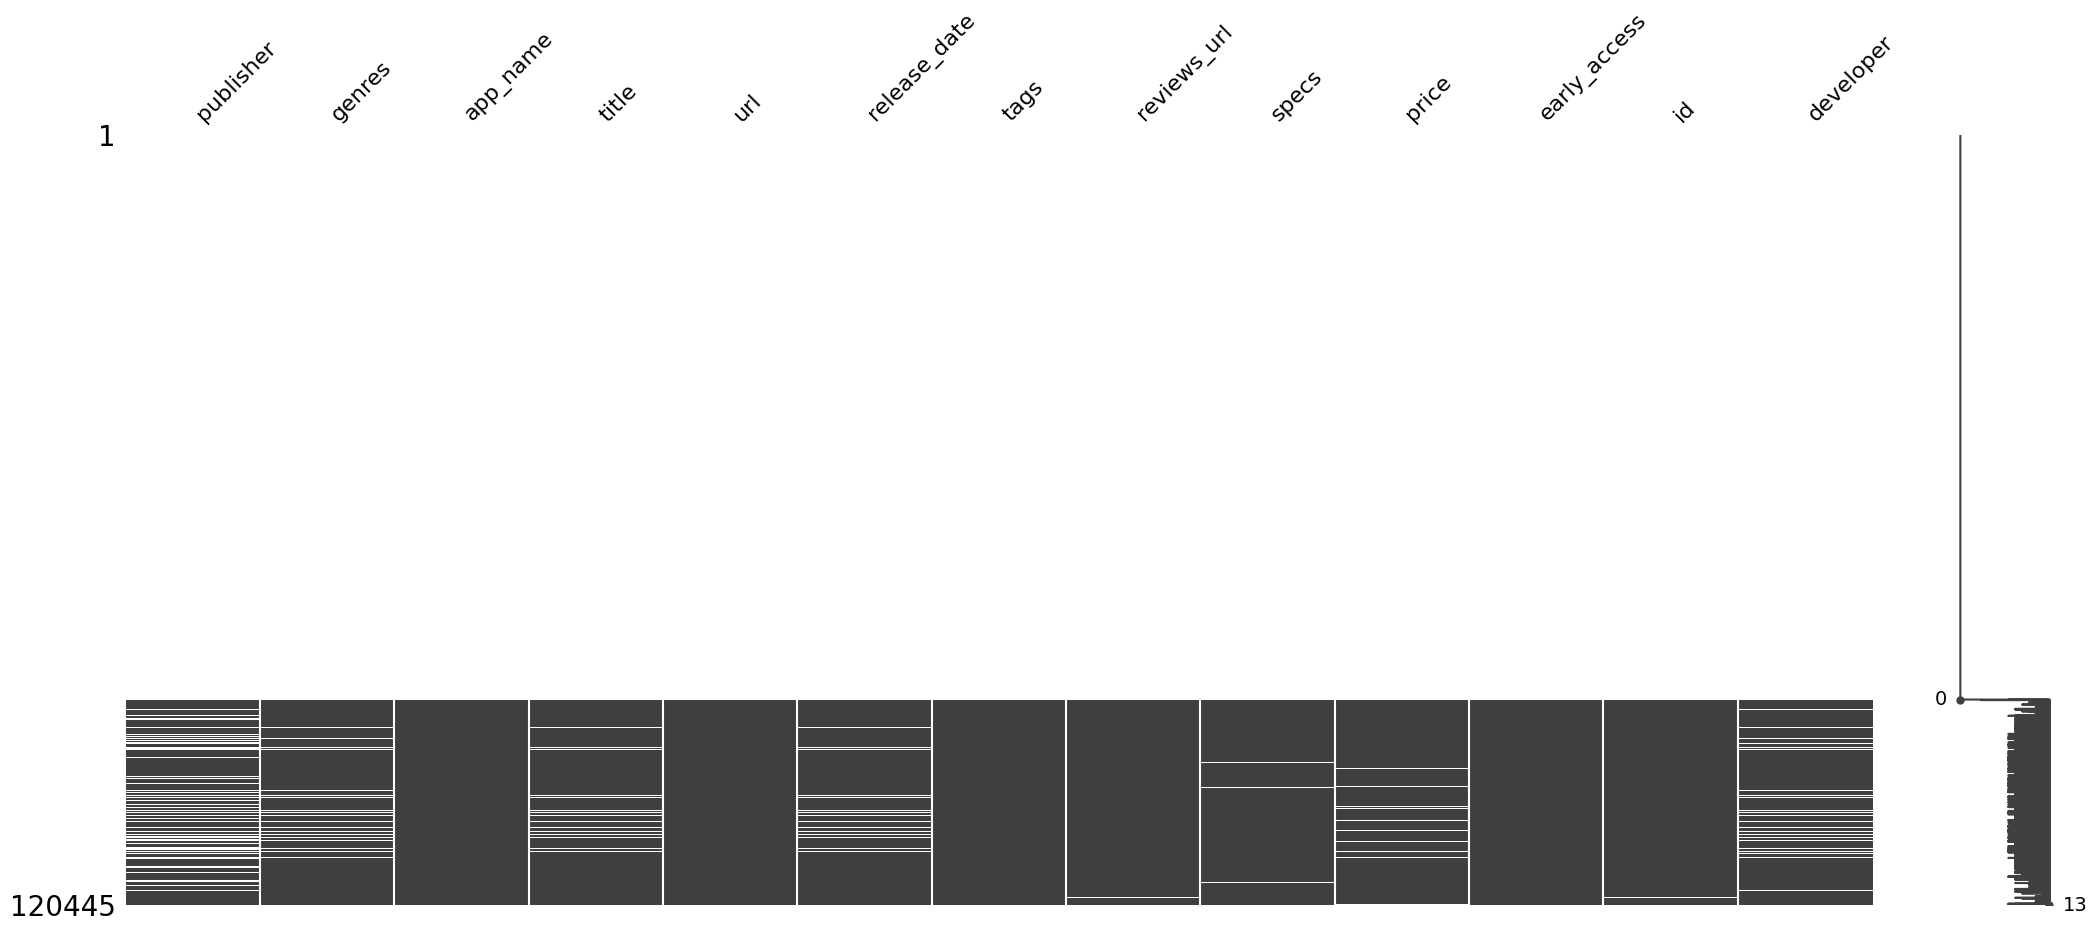

In [62]:
# Visualizar los datos faltantes
msno.matrix(df_steam_games)
plt.show()


- En esta imagen vemos como gran parte del dataset está vacío. Vamos a proceder a limpiarlo.

2. Tratar valores nulos:

Eliminar filas: hay filas con valores nulos, puedemos eliminarlas:

In [63]:
df_steam_games.dropna(inplace=True)

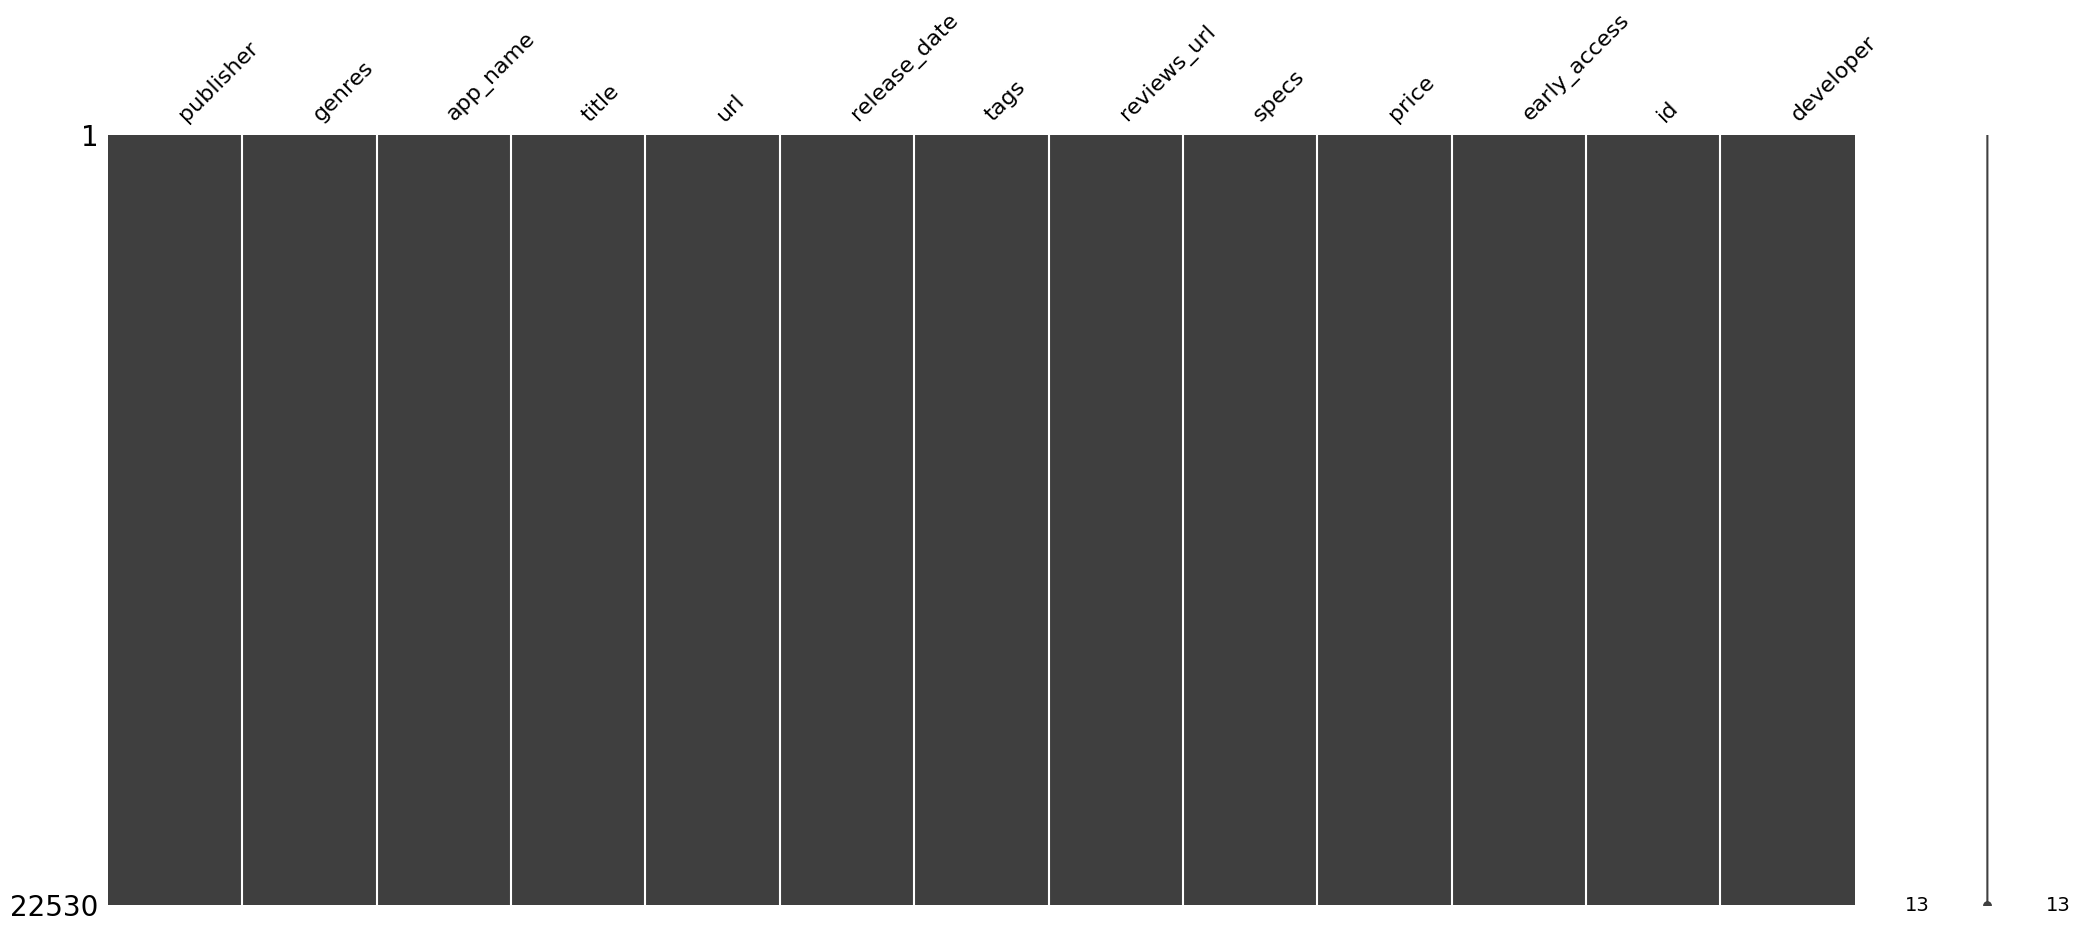

In [64]:
# Visualizar los datos faltantes
msno.matrix(df_steam_games)
plt.show()

- Ahora ya podemos observar que el dataset ya está listo para su posterior tratamiento sin valores nulos y faltantes.

3. Verificar y corregir tipos de datos:

In [65]:
# Ver los tipos de datos actuales
print(df_steam_games.dtypes)

publisher        object
genres           object
app_name         object
title            object
url              object
release_date     object
tags             object
reviews_url      object
specs            object
price            object
early_access    float64
id              float64
developer        object
dtype: object


In [66]:
# Convertir tipos de datos
df_steam_games['price'] = pd.to_numeric(df_steam_games['price'], errors='coerce')
df_steam_games['release_date'] = pd.to_datetime(df_steam_games['release_date'], errors='coerce')

- Se ha convertido price a número y release_date a datetime.

4 - La función safe_literal_eval y el bloque de código que la acompaña están diseñados para convertir cadenas de texto que representan literales de Python en listas.

In [67]:
# Función para evaluar literal de Python de forma segura
def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return val  # Retorna el valor original si no se puede evaluar

# Convertir las columnas a listas de forma segura
columns_to_convert = ['genres', 'tags', 'specs']
for column in columns_to_convert:
    df_steam_games[column] = df_steam_games[column].apply(safe_literal_eval)

# Verificar los tipos de datos
print(df_steam_games.dtypes)
print(df_steam_games.head())

publisher               object
genres                  object
app_name                object
title                   object
url                     object
release_date    datetime64[ns]
tags                    object
reviews_url             object
specs                   object
price                  float64
early_access           float64
id                     float64
developer               object
dtype: object
                 publisher                                             genres  \
88310            Kotoshiro      [Action, Casual, Indie, Simulation, Strategy]   
88311     Making Fun, Inc.               [Free to Play, Indie, RPG, Strategy]   
88312         Poolians.com  [Casual, Free to Play, Indie, Simulation, Sports]   
88313                 彼岸领域                        [Action, Adventure, Casual]   
88315  Trickjump Games Ltd                    [Action, Adventure, Simulation]   

                      app_name                    title  \
88310      Lost Summoner Kitty      L

5. Buscar valores atípicos y consistencia:

- Valores atípicos:

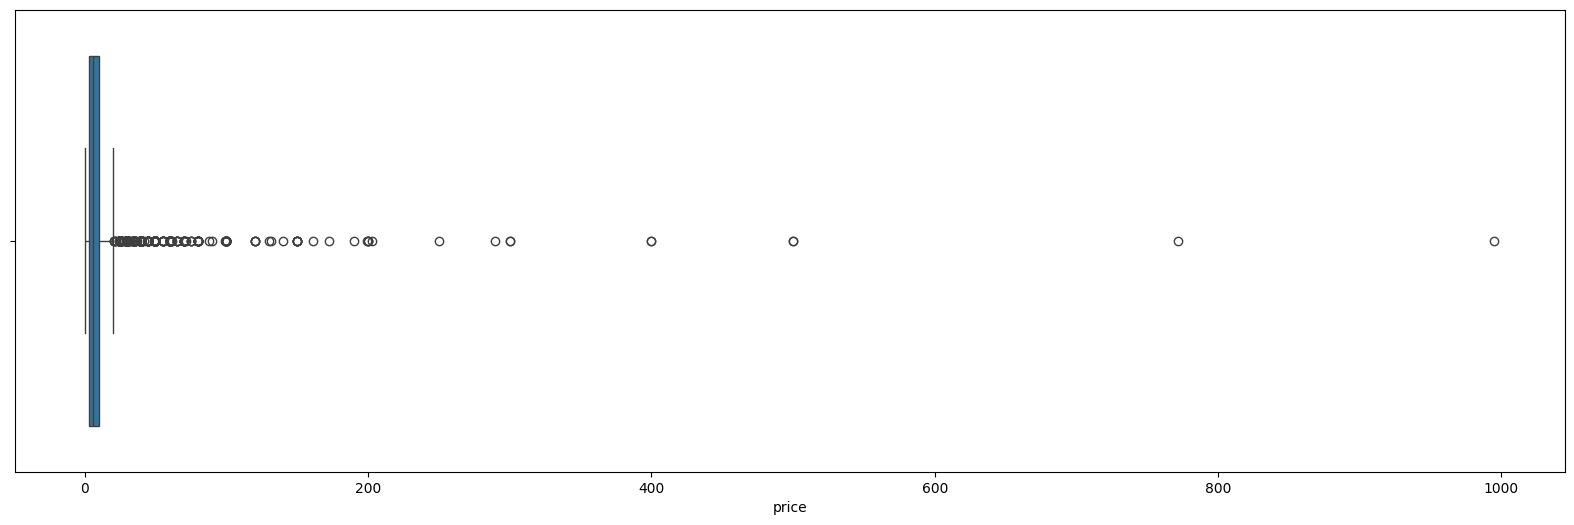

In [68]:
# Configurar el tamaño de la figura
plt.figure(figsize=(20, 6))

# Boxplot para detectar outliers en el precio
sns.boxplot(x=df_steam_games['price'])

# Mostrar el gráfico
plt.show()

- La mayoría de los juegos se encuentran en el rango de precios bajos.
- Se puede observar una **alta concentración** de juegos con precios menores a 20 dólares.
- **La mayoría de los juegos tienen precios accesibles**, lo cual puede indicar una estrategia de mercado enfocada en el volumen de ventas.
- Es importante **considerar la relación precio-calidad** para determinar si los juegos más caros justifican su precio.

- Valores inconsistentes:

In [69]:
# Filtrar por precios negativos
df_steam_games[df_steam_games['price'] < 0]

Empty DataFrame
Columns: [publisher, genres, app_name, title, url, release_date, tags, reviews_url, specs, price, early_access, id, developer]
Index: []

In [70]:
# Filtrar por fechas en el futuro
df_steam_games[df_steam_games['release_date'] > pd.Timestamp.now()]

Empty DataFrame
Columns: [publisher, genres, app_name, title, url, release_date, tags, reviews_url, specs, price, early_access, id, developer]
Index: []

- No existen precios menores a cero y fechas superiores a la fecha actual por lo que que no poseemos valores inconsistentes en el dataset.

5. Valores

**Verificar valores nulos**

In [71]:
print(df_steam_games.isnull().sum())

publisher          0
genres             0
app_name           0
title              0
url                0
release_date      34
tags               0
reviews_url        0
specs              0
price           1308
early_access       0
id                 0
developer          0
dtype: int64


- Como vemos, aún tenemos valores nulos en algunas filas por lo que vamos a imputar datos a través de ML para que sea lo más representativo posible.

**Imputar valores y reemplazar nulos en la columna 'price'**

In [72]:
df_steam_games['price'].fillna(df_steam_games['price'].median(), inplace=True)

C:\Users\londe\AppData\Local\Temp\ipykernel_6440\857654419.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_steam_games['price'].fillna(df_steam_games['price'].median(), inplace=True)


- Una vez detectados los valores nulos en 

**Verificar nuevamente valores nulos**

In [73]:
print(df_steam_games.isnull().sum())

publisher        0
genres           0
app_name         0
title            0
url              0
release_date    34
tags             0
reviews_url      0
specs            0
price            0
early_access     0
id               0
developer        0
dtype: int64


- Las fechas son imposibles de completar por ahora.

**Encontrar valores únicos en la columna 'price'**

In [74]:
# Contar el número de valores únicos en 'price'
unique_prices_count = df_steam_games['price'].nunique()
print("Número de valores únicos en 'price':", unique_prices_count)

Número de valores únicos en 'price': 120


**Contar filas duplicadas**

In [75]:
# Identify columns with list data types
list_columns = df_steam_games.applymap(type).eq(list).any()

# Exclude columns with list data types
subset_columns = df_steam_games.columns[~list_columns]

# Check for duplicates excluding the list columns
duplicates = df_steam_games.duplicated(subset=subset_columns).sum()
print(f"Número de filas duplicadas: {duplicates}")

C:\Users\londe\AppData\Local\Temp\ipykernel_6440\3321489645.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  list_columns = df_steam_games.applymap(type).eq(list).any()


Número de filas duplicadas: 0


**Contar la frecuencia de cada categoría en la columna 'genres'**

In [76]:
genre_counts = df_steam_games['genres'].value_counts()
print("Distribución de géneros:")
print(genre_counts)

Distribución de géneros:
genres
[Action]                                                         1577
[Action, Indie]                                                  1396
[Simulation]                                                     1266
[Strategy]                                                        931
[Action, Adventure, Indie]                                        926
                                                                 ... 
[Action, Casual, Indie, Racing, Strategy]                           1
[Action, Adventure, Massively Multiplayer, Simulation]              1
[Massively Multiplayer, Strategy]                                   1
[Adventure, Casual, Indie, Massively Multiplayer, Simulation]       1
[Adventure, Casual, RPG, Simulation, Early Access]                  1
Name: count, Length: 804, dtype: int64


In [77]:
# Descomponer la columna 'genres' en elementos individuales
all_genres = df_steam_games['genres'].explode()

# Contar la frecuencia de cada género
genre_counts = all_genres.value_counts()

print("Distribución de géneros:")
print(genre_counts)

Distribución de géneros:
genres
Indie                        12693
Action                        9430
Adventure                     7021
Casual                        6283
Strategy                      5213
Simulation                    4724
RPG                           3809
Free to Play                  1458
Early Access                  1360
Sports                        1032
Racing                         947
Massively Multiplayer          813
Design &amp; Illustration      264
Web Publishing                 195
Utilities                      139
Animation &amp; Modeling        83
Education                       53
Software Training               36
Audio Production                30
Video Production                18
Photo Editing                   11
Name: count, dtype: int64


### 3. Análisis Exploratorio

#### **`Estadísticas Descriptivas`**


1. Resumen estadístico de las variables numéricas:

In [78]:
# Resumen estadístico
print("Resumen estadístico de las variables numéricas:")
print(df_steam_games.describe())


Resumen estadístico de las variables numéricas:
                        release_date         price  early_access            id
count                          22496  22530.000000  22530.000000  2.253000e+04
mean   2015-03-20 23:08:58.975817984      9.315963      0.060364  4.307164e+05
min              1983-06-19 00:00:00      0.490000      0.000000  1.000000e+01
25%              2014-07-22 00:00:00      2.990000      0.000000  3.022950e+05
50%              2016-04-08 12:00:00      5.990000      0.000000  4.269285e+05
75%              2017-04-21 00:00:00      9.990000      0.000000  5.807075e+05
max              2021-12-31 00:00:00    995.000000      1.000000  2.028850e+06
std                              NaN     15.278970      0.238165  1.918424e+05


2. Información de los tipos de datos y la cantidad de valores no nulos por columna:

In [79]:
# Información del DataFrame
print("Información del DataFrame:")
print(df_steam_games.info())

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 22530 entries, 88310 to 120443
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   publisher     22530 non-null  object        
 1   genres        22530 non-null  object        
 2   app_name      22530 non-null  object        
 3   title         22530 non-null  object        
 4   url           22530 non-null  object        
 5   release_date  22496 non-null  datetime64[ns]
 6   tags          22530 non-null  object        
 7   reviews_url   22530 non-null  object        
 8   specs         22530 non-null  object        
 9   price         22530 non-null  float64       
 10  early_access  22530 non-null  float64       
 11  id            22530 non-null  float64       
 12  developer     22530 non-null  object        
dtypes: datetime64[ns](1), float64(3), object(9)
memory usage: 2.4+ MB
None


3. Frecuencia de cada valor en una columna categórica:

'publisher'

In [80]:
# Frecuencia de valores en la columna 'publisher'
print("Frecuencia de valores en 'publisher':")
print(df_steam_games['publisher'].value_counts())

Frecuencia de valores en 'publisher':
publisher
Ubisoft                             366
Dovetail Games - Trains             358
Degica                              266
Paradox Interactive                 262
Dovetail Games - Flight             220
                                   ... 
Cannon head interactive               1
LoveTrooper Entertainment L.L.C.      1
Engin Mercan                          1
Fire Engrave                          1
Ben Lovegrove                         1
Name: count, Length: 7834, dtype: int64


'developer'

In [81]:
# Frecuencia de valores en la columna 'developer'
print("Frecuencia de valores en 'developer':")
print(df_steam_games['developer'].value_counts())

Frecuencia de valores en 'developer':
developer
Dovetail Games                           253
KOEI TECMO GAMES CO., LTD.               180
Ubisoft - San Francisco                  178
Capcom                                   107
Paradox Development Studio                97
                                        ... 
Mark Healey                                1
SyKoHPaTh                                  1
Patrick Hofmann                            1
DreamInCode B.V.,Squadron Interactive      1
Kotoshiro                                  1
Name: count, Length: 10275, dtype: int64


#### **`Visualizaciones`**

1. Histograma de la variable 'price':

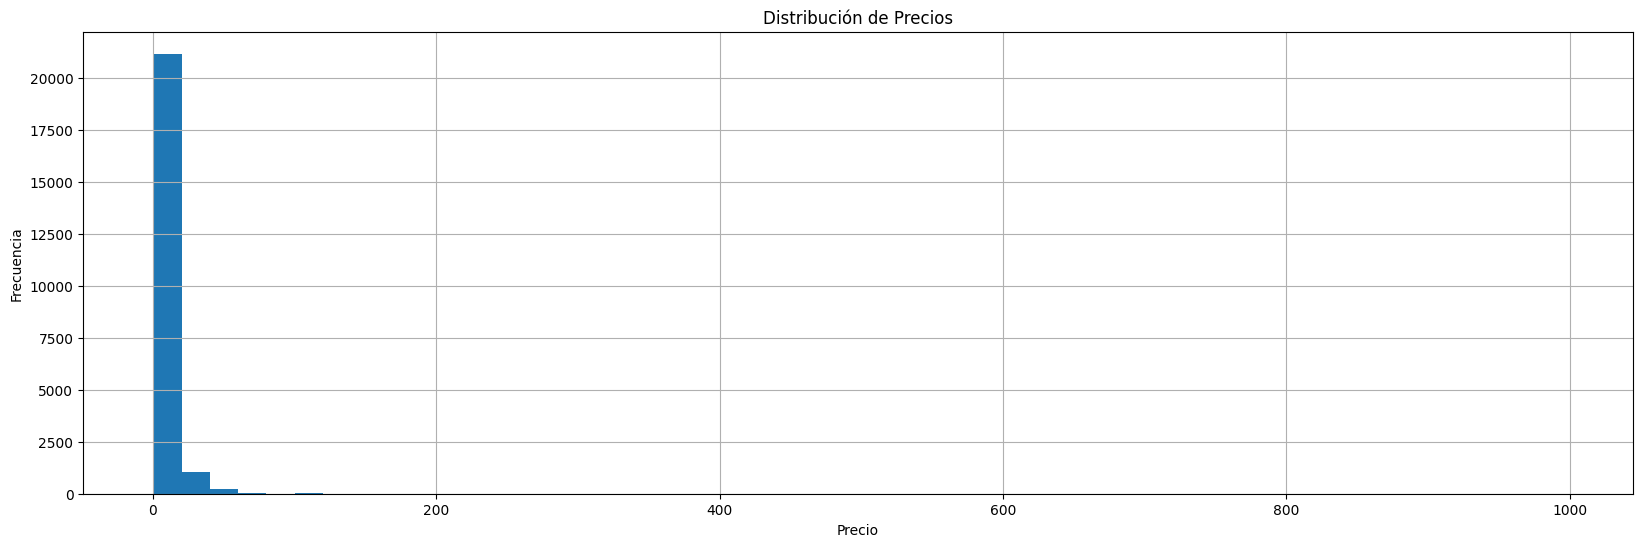

In [82]:
# Histograma de 'price'
plt.figure(figsize=(20, 6))
df_steam_games['price'].hist(bins=50)
plt.title('Distribución de Precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()


2. Diagrama de caja (boxplot) de la variable 'price':

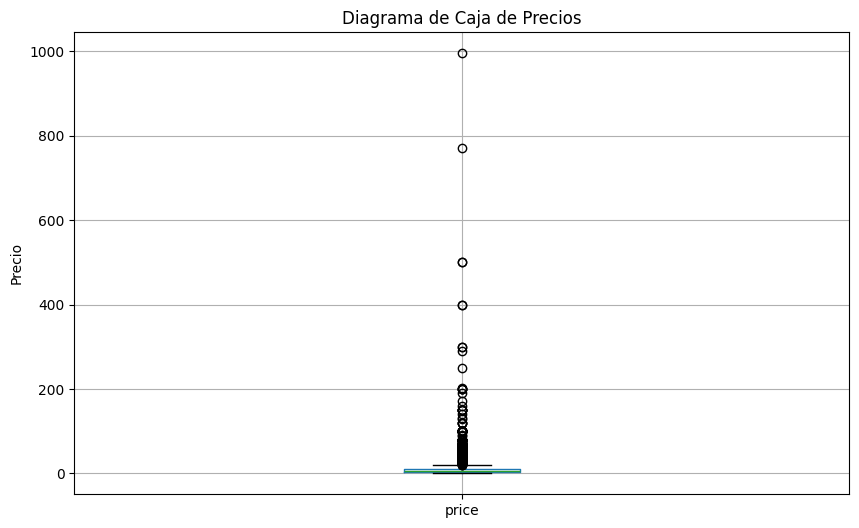

In [83]:
# Boxplot de 'price'
plt.figure(figsize=(10, 6))
df_steam_games.boxplot(column='price')
plt.title('Diagrama de Caja de Precios')
plt.ylabel('Precio')
plt.show()


3. Gráfico de barras para la frecuencia de géneros:



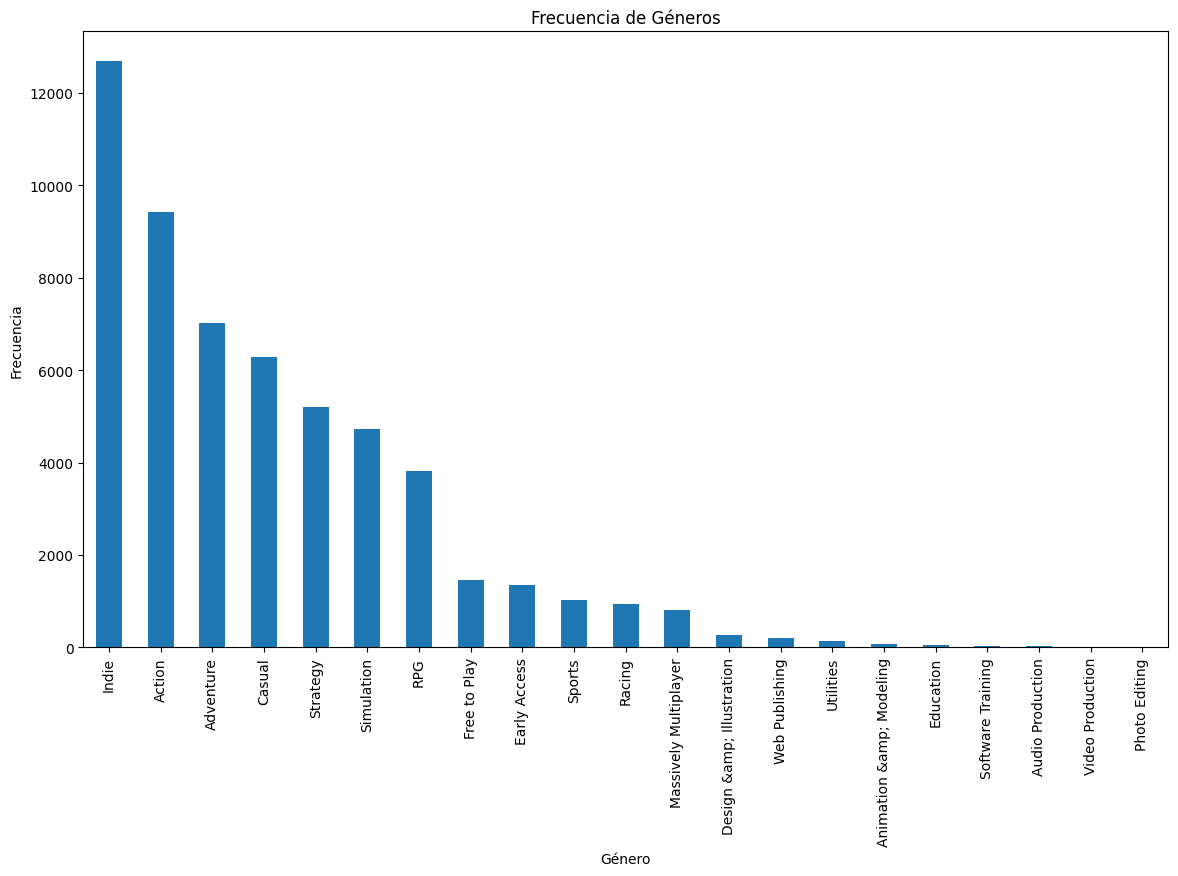

In [84]:
# Contar la frecuencia de cada género
all_genres = df_steam_games['genres'].explode()
genre_counts = all_genres.value_counts()

# Gráfico de barras de géneros
plt.figure(figsize=(14, 8))
genre_counts.plot(kind='bar')
plt.title('Frecuencia de Géneros')
plt.xlabel('Género')
plt.ylabel('Frecuencia')
plt.show()


4. Gráfico de dispersión entre 'price' y 'release_date':



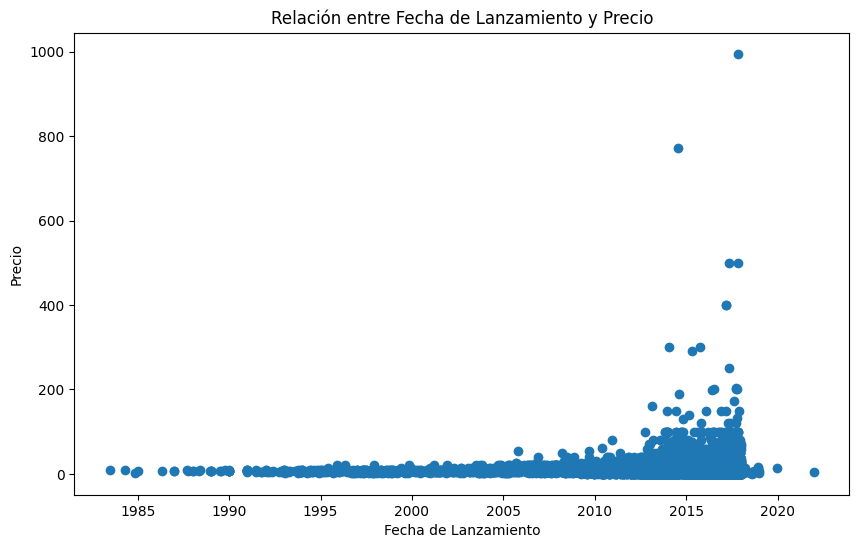

In [85]:
# Convertir 'release_date' a datetime
df_steam_games['release_date'] = pd.to_datetime(df_steam_games['release_date'], errors='coerce')

# Gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(df_steam_games['release_date'], df_steam_games['price'])
plt.title('Relación entre Fecha de Lanzamiento y Precio')
plt.xlabel('Fecha de Lanzamiento')
plt.ylabel('Precio')
plt.show()


#### **`Correlación`**

1. Matriz de correlación:




In [86]:
# Seleccionar solo las columnas numéricas
numeric_df = df_steam_games.select_dtypes(include=['float64', 'int64'])

# Matriz de correlación
print("Matriz de correlación:")
print(numeric_df.corr())


Matriz de correlación:
                 price  early_access        id
price         1.000000      0.021431 -0.050396
early_access  0.021431      1.000000  0.105914
id           -0.050396      0.105914  1.000000


### ¿Qué nos dice esta matriz?

* **price y early_access:** La correlación entre el precio y el acceso anticipado es de 0.021431. Este valor cercano a cero indica que **no existe una relación lineal significativa** entre ambas variables. Es decir, el hecho de que un juego esté en acceso anticipado no influye de manera notable en su precio.
* **price e id:** La correlación entre el precio y el ID del juego es de -0.050396. Nuevamente, este valor cercano a cero sugiere que **no hay una relación lineal apreciable**. El ID del juego, que suele ser un identificador único, no guarda una relación directa con el precio.
* **early_access e id:** La correlación entre el acceso anticipado y el ID es de 0.105914. Si bien es un poco mayor que las anteriores, sigue siendo un valor bajo. Esto indica una **correlación muy débil** entre ambas variables, es decir, no existe una relación lineal clara entre si un juego está en acceso anticipado y su ID.

### Conclusiones generales

* **No hay relaciones lineales fuertes:** Ninguna de las variables presenta una correlación fuerte con las demás.
* **El precio no se correlaciona significativamente:** Ni el acceso anticipado ni el ID del juego parecen influir de manera directa en el precio.
* **Otras variables:** Para entender mejor el precio de los juegos, sería interesante analizar otras variables como el género, la popularidad del desarrollador, las calificaciones de los usuarios, la cantidad de contenido, etc.

### Consideraciones adicionales

* **Correlación no implica causalidad:** Aunque una correlación alta sugiere una relación entre dos variables, no implica necesariamente que una cause la otra. Podría haber otras variables ocultas que influyen en ambas.
* **No linealidad:** Esta matriz solo mide la correlación lineal. Podría existir una relación no lineal entre las variables que no se detecta con este método.
* **Otras técnicas:** Para una exploración más profunda, se pueden utilizar técnicas como el análisis de componentes principales (PCA) o la visualización de datos.

**En resumen,** esta matriz de correlación sugiere que el precio de los juegos en tu conjunto de datos no está fuertemente relacionado con el acceso anticipado ni con el ID del juego. Para obtener una comprensión más completa, sería recomendable explorar otras variables y utilizar técnicas de análisis más avanzadas.

#### **`Análisis de Texto`**


1. Tokenización y frecuencia de palabras en los títulos:

In [87]:
# Tokenización de títulos
titles = df_steam_games['title'].dropna().tolist()
words = [word for title in titles for word in re.findall(r'\b\w+\b', title.lower())]

# Contar la frecuencia de palabras
word_counts = Counter(words)

# Mostrar las 10 palabras más comunes
print("Las 10 palabras más comunes en los títulos:")
print(word_counts.most_common(10))


Las 10 palabras más comunes en los títulos:
[('the', 3387), ('of', 2784), ('pack', 1935), ('2', 1367), ('s', 1173), ('edition', 883), ('on', 834), ('soundtrack', 828), ('add', 731), ('simulator', 629)]


2. Nube de palabras:

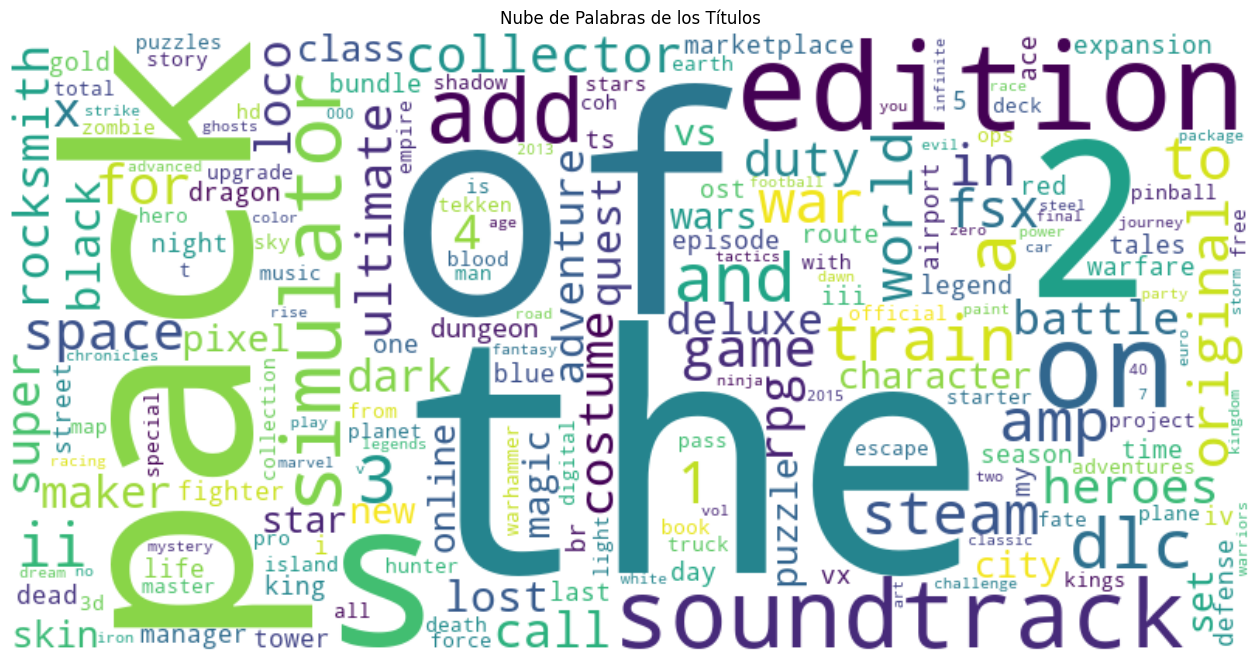

In [88]:
# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Mostrar la nube de palabras
plt.figure(figsize=(16, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras de los Títulos')
plt.show()


## **`2. EDA user_items.json`**

### 1. Expandir la Columna de Listas en un DataFrame Separado:

Desanidamos los diccionarios en la columna items y convertimos cada uno en una fila separada en un nuevo DataFrame. Esto nos permitirá analizar y procesar los datos de manera más eficiente.

In [89]:
# Definir una función para expandir la columna de listas
def expand_items(row):
    user_id = row['user_id']
    items_list = row['items']
    expanded_items = []
    for item in items_list:
        item['user_id'] = user_id
        expanded_items.append(item)
    return pd.DataFrame(expanded_items)

# Aplicar la función a cada fila del DataFrame
expanded_df = pd.concat(df_users_items.apply(expand_items, axis=1).tolist(), ignore_index=True)

# Unir el DataFrame expandido con el DataFrame original
df_expanded = df_users_items.drop(columns=['items']).merge(expanded_df, on='user_id', how='left')

df_users_items = df_expanded

### 2. Limpieza y Preprocesamiento de los Datos

#### 1. Identificación y Tratamiento de Valores Faltantes

Primero, verificamos los valores faltantes en el DataFrame:

In [90]:
# Verifica los valores faltantes en cada columna
print(df_users_items.isnull().sum())

user_id                 0
items_count             0
steam_id                0
user_url                0
item_id             16806
item_name           16806
playtime_forever    16806
playtime_2weeks     16806
dtype: int64


Eliminar filas con valores nulos:

In [91]:
df_users_items = df_users_items.dropna()

In [92]:
# Verifica los valores faltantes en cada columna
print(df_users_items.isnull().sum())

user_id             0
items_count         0
steam_id            0
user_url            0
item_id             0
item_name           0
playtime_forever    0
playtime_2weeks     0
dtype: int64


#### 2. Asegurarse de los Tipos de Datos Correctos

Convierte las columnas a los tipos de datos correctos:

In [93]:
# Verifica el tipo de datos
print(df_users_items.dtypes)


user_id              object
items_count           int64
steam_id              int64
user_url             object
item_id              object
item_name            object
playtime_forever    float64
playtime_2weeks     float64
dtype: object


#### 3. Verificación de la Consistencia de Datos

Buscar valores atípicos en playtime_forever y playtime_2weeks:

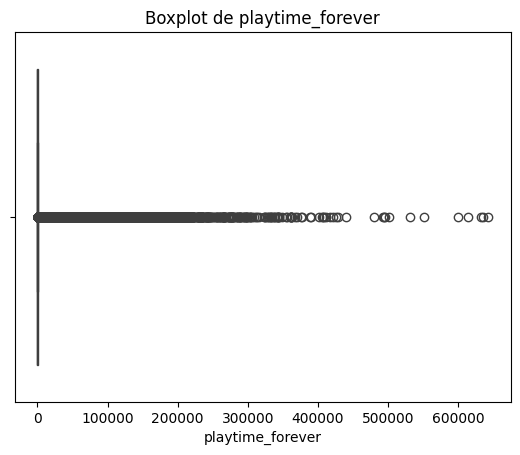

In [94]:
# Boxplot para `playtime_forever`
sns.boxplot(x=df_users_items['playtime_forever'])
plt.title('Boxplot de playtime_forever')
plt.show()

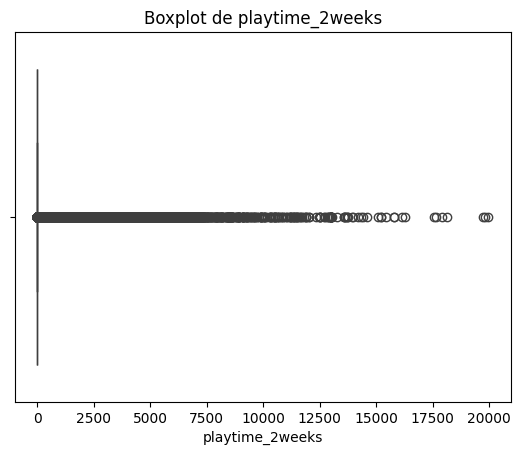

In [95]:
# Boxplot para `playtime_2weeks`
sns.boxplot(x=df_users_items['playtime_2weeks'])
plt.title('Boxplot de playtime_2weeks')
plt.show()

Verificar URLs:

In [96]:
# Verifica si hay URLs vacías o mal formateadas
invalid_urls = df_users_items[~df_users_items['user_url'].str.startswith('http')]
print(invalid_urls)

Empty DataFrame
Columns: [user_id, items_count, steam_id, user_url, item_id, item_name, playtime_forever, playtime_2weeks]
Index: []


### 3. Análisis Exploratorio

#### 1. Estadísticas Descriptivas

##### 1.1 Resumen Estadístico de las Variables Numéricas


In [97]:
# Estadísticas descriptivas de las variables numéricas
print(df_users_items.describe())

        items_count      steam_id  playtime_forever  playtime_2weeks
count  5.272423e+06  5.272423e+06      5.272423e+06     5.272423e+06
mean   3.127273e+02  7.656120e+16      9.934979e+02     9.185718e+00
std    6.863892e+02  3.915834e+07      5.426167e+03     1.406467e+02
min    1.000000e+00  7.656120e+16      0.000000e+00     0.000000e+00
25%    7.200000e+01  7.656120e+16      0.000000e+00     0.000000e+00
50%    1.380000e+02  7.656120e+16      3.400000e+01     0.000000e+00
75%    2.760000e+02  7.656120e+16      3.560000e+02     0.000000e+00
max    7.762000e+03  7.656120e+16      6.427730e+05     1.996700e+04


##### 1.2 Información del DataFrame


In [98]:
# Información sobre el DataFrame
print(df_users_items.info())

<class 'pandas.core.frame.DataFrame'>
Index: 5272423 entries, 0 to 5289227
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           object 
 1   items_count       int64  
 2   steam_id          int64  
 3   user_url          object 
 4   item_id           object 
 5   item_name         object 
 6   playtime_forever  float64
 7   playtime_2weeks   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 362.0+ MB
None


##### 1.3 Frecuencia de Valores en la Columna Categórica 'item_name'


In [99]:
# Frecuencia de cada valor en la columna 'item_name'
print(df_users_items['item_name'].value_counts())

item_name
Dota 2 Test                         50449
Counter-Strike: Global Offensive    44682
Garry's Mod                         44223
Unturned                            39508
Left 4 Dead 2 Beta                  37818
                                    ...  
The Inner Sea                           1
Induction                               1
A Quiver of Crows                       1
Soft Body                               1
Sally's Law                             1
Name: count, Length: 10947, dtype: int64


#### 2. Visualizaciones

##### 2.1 Histograma

Para mostrar la distribución de playtime_forever:

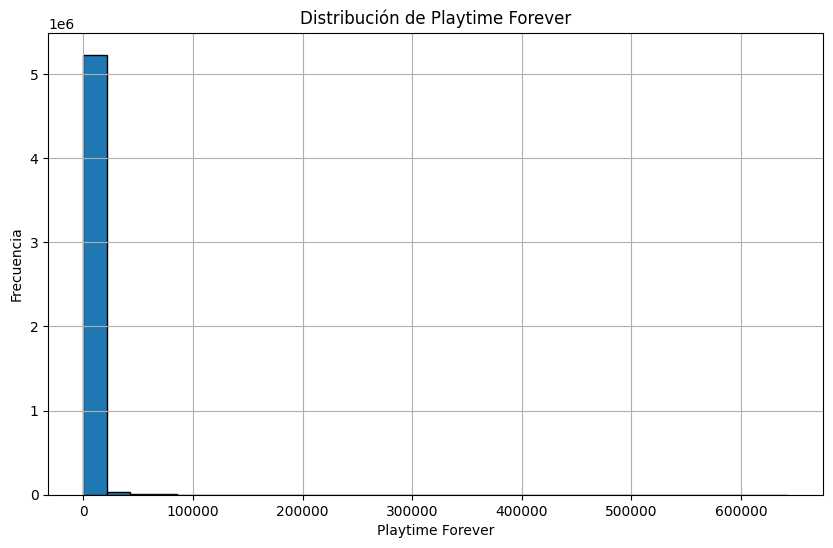

In [100]:
# Histograma de la columna 'playtime_forever'
plt.figure(figsize=(10, 6))
plt.hist(df_users_items['playtime_forever'].dropna(), bins=30, edgecolor='k')
plt.title('Distribución de Playtime Forever')
plt.xlabel('Playtime Forever')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

##### 2.2 Diagrama de Caja (Boxplot)


Para identificar valores atípicos en playtime_forever:

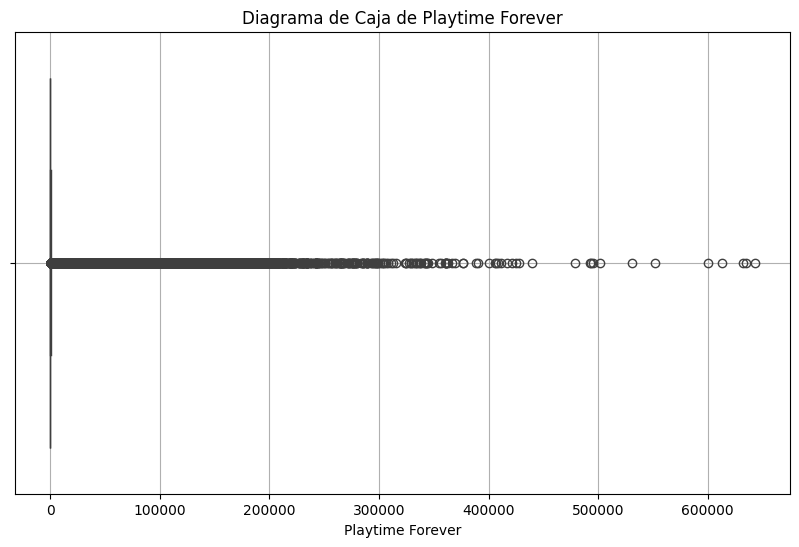

In [101]:
# Diagrama de caja de la columna 'playtime_forever'
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_users_items['playtime_forever'])
plt.title('Diagrama de Caja de Playtime Forever')
plt.xlabel('Playtime Forever')
plt.grid(True)
plt.show()


##### 2.3 Gráfico de Barras

Para comparar la frecuencia de item_name:

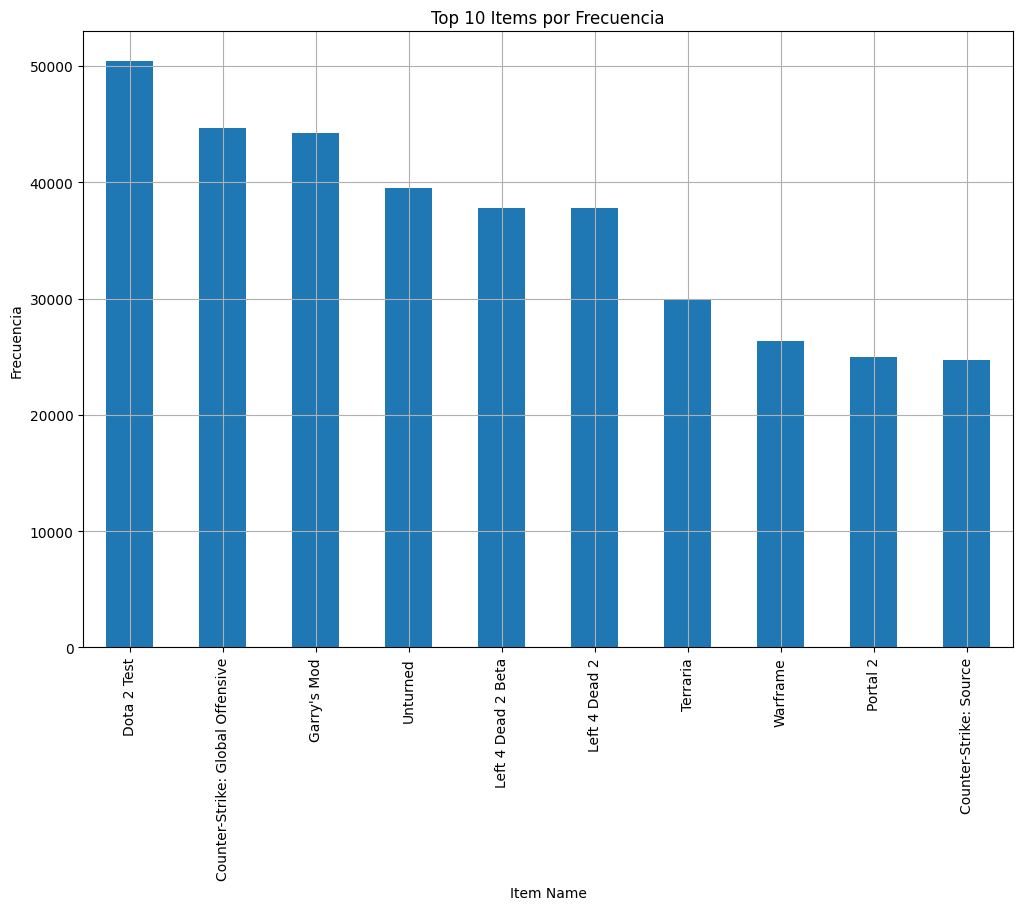

In [102]:
# Gráfico de barras de la columna 'item_name'
plt.figure(figsize=(12, 8))
df_users_items['item_name'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Items por Frecuencia')
plt.xlabel('Item Name')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


##### 2.4 Gráfico de Dispersión


Para explorar la relación entre playtime_forever y playtime_2weeks:



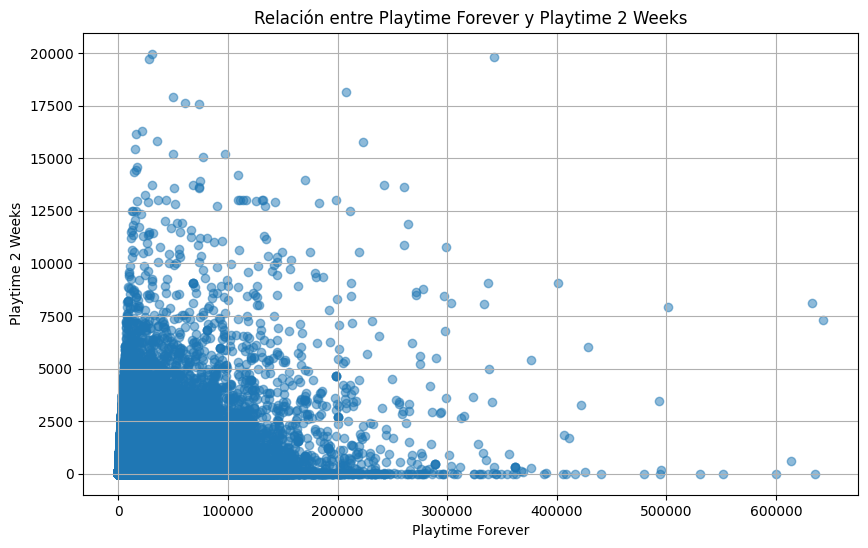

In [103]:
# Gráfico de dispersión de 'playtime_forever' vs 'playtime_2weeks'
plt.figure(figsize=(10, 6))
plt.scatter(df_users_items['playtime_forever'], df_users_items['playtime_2weeks'], alpha=0.5)
plt.title('Relación entre Playtime Forever y Playtime 2 Weeks')
plt.xlabel('Playtime Forever')
plt.ylabel('Playtime 2 Weeks')
plt.grid(True)
plt.show()

#### 3. Correlación

##### 3.1 Matriz de Correlación


In [104]:
# Seleccionamos solo las columnas numéricas para calcular la matriz de correlación
numerical_columns = df_users_items[['items_count', 'item_id', 'playtime_forever', 'playtime_2weeks']]

# Calculamos la matriz de correlación
correlation_matrix = numerical_columns.corr()

# Imprimimos la matriz de correlación
print(correlation_matrix)


                  items_count   item_id  playtime_forever  playtime_2weeks
items_count          1.000000  0.104781         -0.044196        -0.015130
item_id              0.104781  1.000000         -0.076161         0.005943
playtime_forever    -0.044196 -0.076161          1.000000         0.312363
playtime_2weeks     -0.015130  0.005943          0.312363         1.000000


#### 4. Análisis de Texto

4.1 Tokenización y Frecuencia de Palabras

In [105]:
nltk.download('punkt')
nltk.download('stopwords')

# Tokenización y frecuencia de palabras en 'item_name'
stop_words = set(stopwords.words('english'))
tokens = word_tokenize(' '.join(df_users_items['item_name'].dropna().astype(str)))
filtered_tokens = [word for word in tokens if word.lower() not in stop_words and word.isalnum()]

# Contar frecuencia de palabras
word_freq = Counter(filtered_tokens)
print(word_freq.most_common(10))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\londe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\londe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('2', 714078), ('II', 163072), ('Edition', 161763), ('Dead', 152819), ('3', 125151), ('War', 119765), ('4', 118390), ('Heroes', 90930), ('Call', 87634), ('Left', 82481)]


4.2 Nube de Palabras


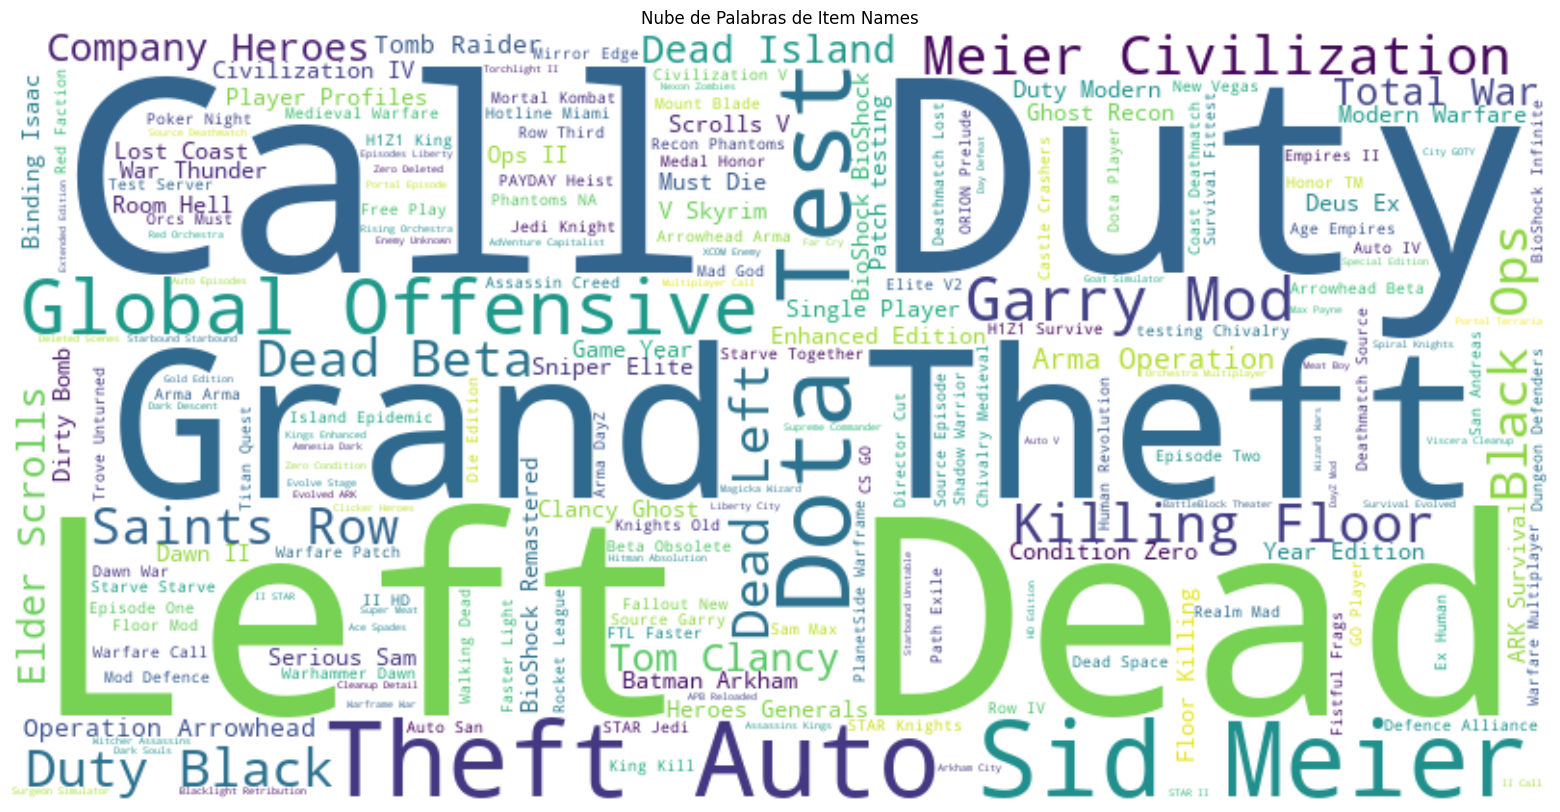

In [106]:
# Crear y mostrar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_tokens))

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras de Item Names')
plt.show()

## **`3. EDA user_reviews.json`**

### 1. Expandir las Listas de Diccionarios


In [107]:
# Definir una función para expandir la columna de listas de diccionarios
def expand_reviews(row):
    user_id = row['user_id']
    reviews_list = row['reviews']
    expanded_reviews = []
    for review in reviews_list:
        review['user_id'] = user_id
        expanded_reviews.append(review)
    return pd.DataFrame(expanded_reviews)

# Aplicar la función a cada fila del DataFrame
expanded_df = pd.concat(df_users_reviews.apply(expand_reviews, axis=1).tolist(), ignore_index=True)

# Unir el DataFrame expandido con el DataFrame original
df_expanded = df_users_reviews.drop(columns=['reviews']).merge(expanded_df, on='user_id', how='left')

df_users_reviews = df_expanded

### 2. Limpieza y Preprocesamiento de los Datos

#### a. Valores faltantes
Primero, identificamos y tratamos los valores nulos:

In [108]:
print("Valores nulos por columna:")
print(df_users_reviews.isnull().sum())

df_users_reviews = df_users_reviews.dropna()  # Elimina las filas con valores nulos

print("Valores nulos por columna:")
print(df_users_reviews.isnull().sum())


Valores nulos por columna:
user_id         0
user_url        0
funny          27
posted         27
last_edited    27
item_id        27
helpful        27
recommend      27
review         27
dtype: int64
Valores nulos por columna:
user_id        0
user_url       0
funny          0
posted         0
last_edited    0
item_id        0
helpful        0
recommend      0
review         0
dtype: int64


#### b. Tipos de datos
Nos aseguramos de que los tipos de datos sean los correctos pasando posted y last_edited a tipo fecha en formato datetime>

In [109]:
# Función para convertir la fecha
def convert_date(date_str):
    # Utilizar expresiones regulares para extraer el mes, día y año
    match = re.search(r"(\w+) (\d{1,2}), (\d{4})", date_str)
    if match:
        month_str, day_str, year_str = match.groups()
        
        # Mapear nombres de meses a números
        dicc_mes = {
            "January": "01",
            "February": "02",
            "March": "03",
            "April": "04",
            "May": "05",
            "June": "06",
            "July": "07",
            "August": "08",
            "September": "09",
            "October": "10",
            "November": "11",
            "December": "12"
        }
        
        # Formatear la fecha como "YYYY/MM/DD"
        fecha_formateada = f"{year_str}/{dicc_mes[month_str]}/{day_str}"
        
        return fecha_formateada
    else:
        return None

# Aplicar la función a las columnas "posted" y "last_edited" del DataFrame
df_users_reviews["posted"] = df_users_reviews["posted"].apply(convert_date)
df_users_reviews["last_edited"] = df_users_reviews["last_edited"].apply(convert_date)

# Convertir las columnas al tipo datetime
df_users_reviews["posted"] = pd.to_datetime(df_users_reviews["posted"], format="%Y/%m/%d", errors='coerce')
df_users_reviews["last_edited"] = pd.to_datetime(df_users_reviews["last_edited"], format="%Y/%m/%d", errors='coerce')

# Verificar los tipos de datos de las columnas
print(df_users_reviews.dtypes)

# Mostrar el DataFrame resultante
print(df_users_reviews.head())


user_id                object
user_url               object
funny                  object
posted         datetime64[ns]
last_edited    datetime64[ns]
item_id                object
helpful                object
recommend              object
review                 object
dtype: object
             user_id                                           user_url funny  \
0  76561197970982479  http://steamcommunity.com/profiles/76561197970...         
1  76561197970982479  http://steamcommunity.com/profiles/76561197970...         
2  76561197970982479  http://steamcommunity.com/profiles/76561197970...         
3            js41637               http://steamcommunity.com/id/js41637         
4            js41637               http://steamcommunity.com/id/js41637         

      posted last_edited item_id  \
0 2011-11-05         NaT    1250   
1 2011-07-15         NaT   22200   
2 2011-04-21         NaT   43110   
3 2014-06-24         NaT  251610   
4 2013-09-08         NaT  227300   

            

C:\Users\londe\AppData\Local\Temp\ipykernel_6440\3737979601.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_reviews["posted"] = df_users_reviews["posted"].apply(convert_date)
C:\Users\londe\AppData\Local\Temp\ipykernel_6440\3737979601.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_reviews["last_edited"] = df_users_reviews["last_edited"].apply(convert_date)
C:\Users\londe\AppData\Local\Temp\ipykernel_6440\3737979601.py:36: SettingWithCopyWarning: 
A value is trying to be set on a

Nos Aseguramos de que 'helpful' y 'recommend' sean del tipo correcto

In [110]:
df_users_reviews['helpful'] = df_users_reviews['helpful'].astype(str)
df_users_reviews['recommend'] = df_users_reviews['recommend'].astype(bool)

print("Tipos de datos después de la conversión:\n", df_users_reviews.dtypes)


Tipos de datos después de la conversión:
 user_id                object
user_url               object
funny                  object
posted         datetime64[ns]
last_edited    datetime64[ns]
item_id                object
helpful                object
recommend                bool
review                 object
dtype: object


C:\Users\londe\AppData\Local\Temp\ipykernel_6440\2281417219.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_reviews['helpful'] = df_users_reviews['helpful'].astype(str)
C:\Users\londe\AppData\Local\Temp\ipykernel_6440\2281417219.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_reviews['recommend'] = df_users_reviews['recommend'].astype(bool)


#### c. Consistencia de datos
Verificamos la consistencia de los datos, buscando valores atípicos y fechas incorrectas:

In [111]:
# Verificar valores atípicos en 'helpful'
print(df_users_reviews['helpful'].value_counts())

helpful
No ratings yet                                       31059
1 of 1 people (100%) found this review helpful        6906
0 of 1 people (0%) found this review helpful          4166
1 of 2 people (50%) found this review helpful         2561
2 of 2 people (100%) found this review helpful        1910
                                                     ...  
21 of 83 people (25%) found this review helpful          1
130 of 142 people (92%) found this review helpful        1
2 of 49 people (4%) found this review helpful            1
40 of 52 people (77%) found this review helpful          1
2 of 21 people (10%) found this review helpful           1
Name: count, Length: 1344, dtype: int64


In [112]:
# Revisar valores atípicos en 'posted' (fechas futuras, etc.)
print("Fechas mínimas y máximas:\n", df_users_reviews['posted'].min(), df_users_reviews['posted'].max())

Fechas mínimas y máximas:
 2010-10-16 00:00:00 2015-12-31 00:00:00


#### d. Transformaciión de "helpful"

In [113]:
# Función para extraer la proporción de votos útiles
def extract_helpfulness(helpful_str):
    if helpful_str == 'No ratings yet':
        return None  # Opcional: podrías retornar 0 o algún otro valor si lo prefieres
    match = re.search(r'(\d+) of (\d+)', helpful_str)
    if match:
        helpful_votes, total_votes = map(int, match.groups())
        return helpful_votes / total_votes if total_votes > 0 else 0
    return None

# Aplicar la función a la columna "helpful" para crear una nueva columna "helpfulness_ratio"
df_users_reviews['helpfulness_ratio'] = df_users_reviews['helpful'].apply(extract_helpfulness)

# Mostrar las primeras filas del DataFrame para verificar el resultado
print(df_users_reviews[['helpful', 'helpfulness_ratio']].head())

                                           helpful  helpfulness_ratio
0                                   No ratings yet                NaN
1                                   No ratings yet                NaN
2                                   No ratings yet                NaN
3  15 of 20 people (75%) found this review helpful               0.75
4     0 of 1 people (0%) found this review helpful               0.00


C:\Users\londe\AppData\Local\Temp\ipykernel_6440\2185687587.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_reviews['helpfulness_ratio'] = df_users_reviews['helpful'].apply(extract_helpfulness)


#### e. Función para extraer el número de personas que encontraron la revisión divertida


In [114]:
def extract_funny(funny_str):
    if pd.isna(funny_str) or funny_str == '':
        return 0
    match = re.search(r'(\d+) person', funny_str)
    if match:
        return int(match.group(1))
    return 0

# Aplicar la función a la columna "funny" para crear una nueva columna "funny_count"
df_users_reviews['funny_count'] = df_users_reviews['funny'].apply(extract_funny)

# Mostrar las primeras filas del DataFrame para verificar el resultado
print(df_users_reviews[['funny', 'funny_count']].head(10))

  funny  funny_count
0                  0
1                  0
2                  0
3                  0
4                  0
5                  0
6                  0
7                  0
8                  0
9                  0


C:\Users\londe\AppData\Local\Temp\ipykernel_6440\1884140340.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_reviews['funny_count'] = df_users_reviews['funny'].apply(extract_funny)


### 2. Análisis Exploratorio

#### a. Estadísticas descriptivas
Obtenemos un resumen estadístico de las variables numéricas:

In [115]:
print(df_users_reviews.describe())

                              posted                    last_edited  \
count                          50574                           4395   
mean   2014-09-10 06:56:50.796061184  2015-01-13 12:02:47.098975744   
min              2010-10-16 00:00:00            2013-11-25 00:00:00   
25%              2014-02-21 00:00:00            2014-06-30 12:00:00   
50%              2014-09-13 00:00:00            2015-02-04 00:00:00   
75%              2015-05-06 00:00:00            2015-07-25 12:00:00   
max              2015-12-31 00:00:00            2015-12-31 00:00:00   
std                              NaN                            NaN   

       helpfulness_ratio   funny_count  
count       30019.000000  61078.000000  
mean            0.963662      0.088019  
min             0.000000      0.000000  
25%             0.250000      0.000000  
50%             0.600000      0.000000  
75%             1.000000      0.000000  
max           981.000000      1.000000  
std            16.404954      0.

In [116]:
print(df_users_reviews.info())

<class 'pandas.core.frame.DataFrame'>
Index: 61078 entries, 0 to 61104
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            61078 non-null  object        
 1   user_url           61078 non-null  object        
 2   funny              61078 non-null  object        
 3   posted             50574 non-null  datetime64[ns]
 4   last_edited        4395 non-null   datetime64[ns]
 5   item_id            61078 non-null  object        
 6   helpful            61078 non-null  object        
 7   recommend          61078 non-null  bool          
 8   review             61078 non-null  object        
 9   helpfulness_ratio  30019 non-null  float64       
 10  funny_count        61078 non-null  int64         
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1), object(6)
memory usage: 5.2+ MB
None


In [117]:
print(df_users_reviews['recommend'].value_counts())

recommend
True     54060
False     7018
Name: count, dtype: int64


#### b. Visualizaciones

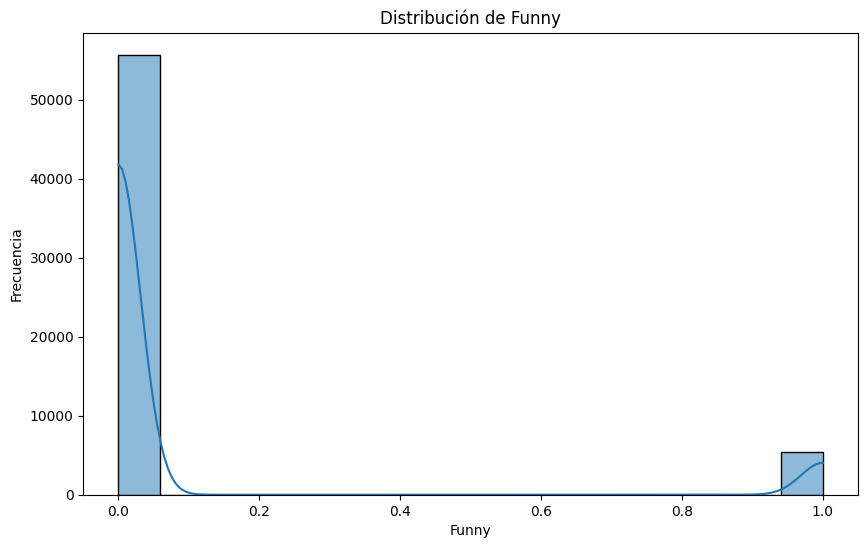

In [118]:
# Histograma de la columna 'funny'
plt.figure(figsize=(10, 6))
sns.histplot(df_users_reviews['funny_count'], kde=True)
plt.title('Distribución de Funny')
plt.xlabel('Funny')
plt.ylabel('Frecuencia')
plt.show()

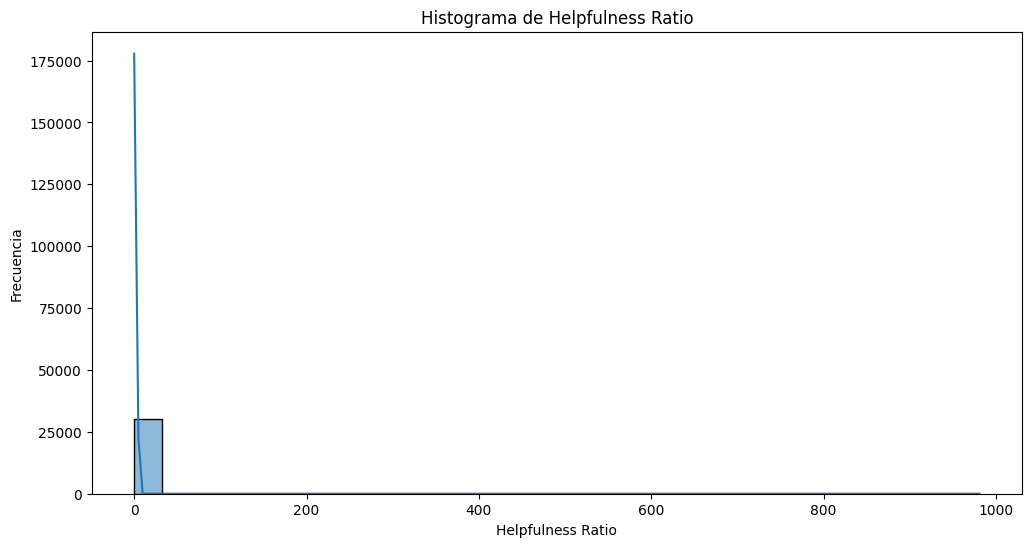

In [119]:
# Histograma de helpfulness_ratio
plt.figure(figsize=(12, 6))
sns.histplot(df_users_reviews['helpfulness_ratio'].dropna(), bins=30, kde=True)
plt.title('Histograma de Helpfulness Ratio')
plt.xlabel('Helpfulness Ratio')
plt.ylabel('Frecuencia')
plt.show()

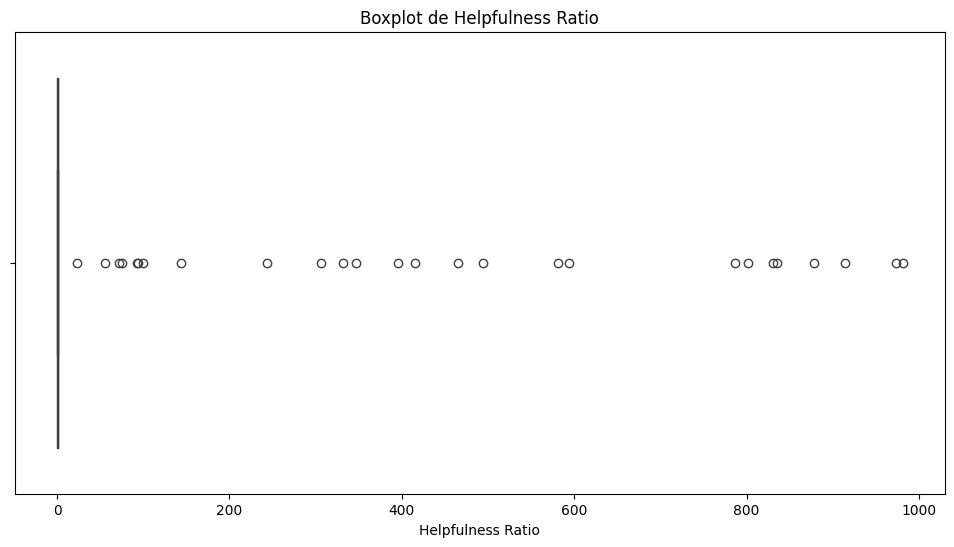

In [120]:
# Diagrama de caja (boxplot) de helpfulness_ratio
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_users_reviews['helpfulness_ratio'].dropna())
plt.title('Boxplot de Helpfulness Ratio')
plt.xlabel('Helpfulness Ratio')
plt.show()

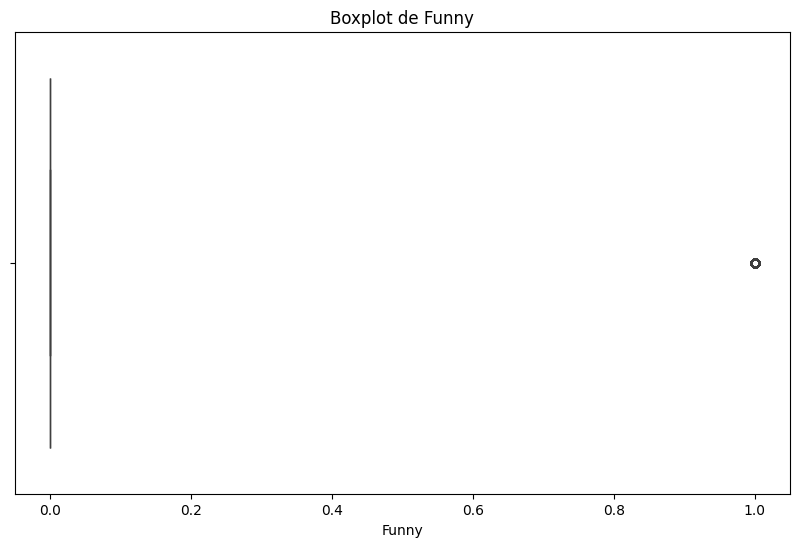

In [121]:
# Diagrama de caja para identificar valores atípicos en 'funny'
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_users_reviews['funny_count'])
plt.title('Boxplot de Funny')
plt.xlabel('Funny')
plt.show()

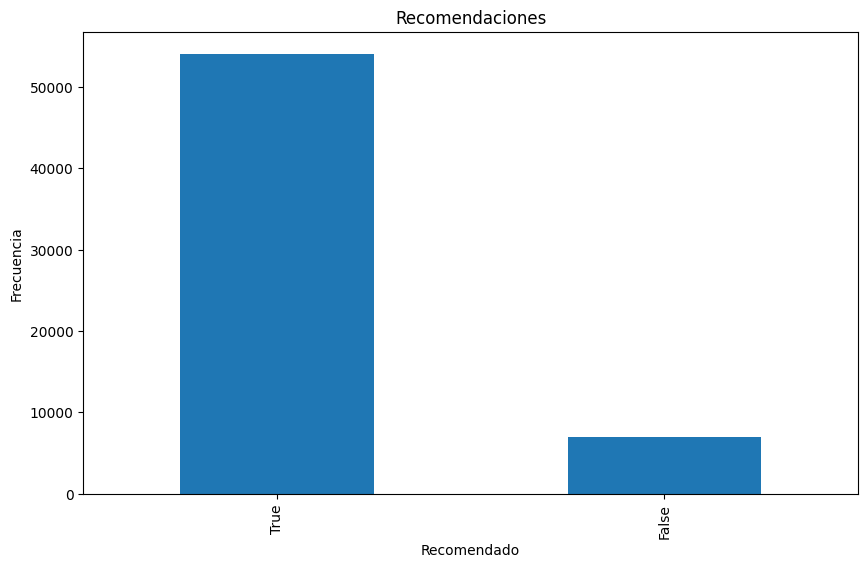

In [122]:
# Gráfico de barras para la columna 'recommend'
plt.figure(figsize=(10, 6))
df_users_reviews['recommend'].value_counts().plot(kind='bar')
plt.title('Recomendaciones')
plt.xlabel('Recomendado')
plt.ylabel('Frecuencia')
plt.show()

#### d. Análisis de texto
1 - Realizamos el análisis de texto:

In [123]:
# Tokenización de la columna 'review'
df_users_reviews['tokens'] = df_users_reviews['review'].apply(lambda x: word_tokenize(x.lower()))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\londe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\londe\AppData\Local\Temp\ipykernel_6440\3328411878.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_reviews['tokens'] = df_users_reviews['review'].apply(lambda x: word_tokenize(x.lower()))


In [124]:
# Frecuencia de palabras
all_words = [word for tokens in df_users_reviews['tokens'] for word in tokens]
word_freq = Counter(all_words)
print("Frecuencia de palabras:\n", word_freq.most_common(10))

Frecuencia de palabras:
 [(',', 93738), ('the', 89992), ('.', 82787), ('and', 61842), ('game', 61149), ('a', 60521), ('!', 56810), ('to', 54533), ('i', 48225), ('it', 46443)]


2 - Nube de palabras

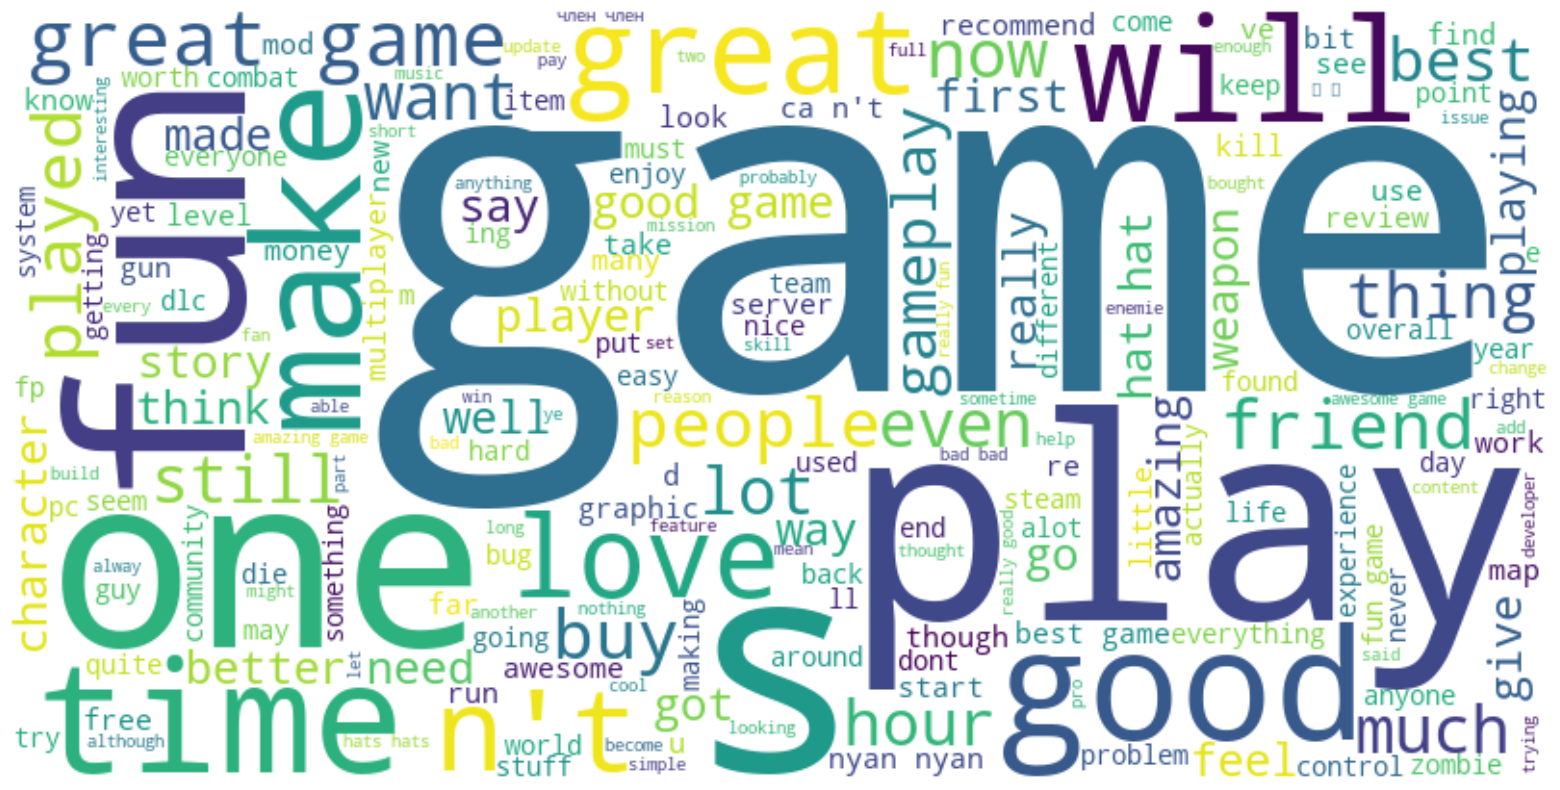

In [125]:
# Nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(all_words))
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Feature Engineering: Analisis de Sentimiento 

Crea una nueva columna llamada "sentiment_analysis" utilizando análisis de sentimiento con NLP en las reseñas de usuarios. Esta columna debe tener valores 0 para malas reseñas, 1 para reseñas neutrales y 2 para reseñas positivas.

In [126]:
# Descargar el paquete de análisis de sentimientos de nltk
nltk.download('vader_lexicon')

# Inicializar el analizador de sentimientos
sia = SentimentIntensityAnalyzer()

# Función para convertir la puntuación de sentimiento en categorías
def classify_sentiment(review):
    if pd.isna(review) or review.strip() == '':
        return 1  # Neutral si no hay reseña
    sentiment_score = sia.polarity_scores(review)['compound']
    if sentiment_score >= 0.05:
        return 2  # Positivo
    elif sentiment_score <= -0.05:
        return 0  # Negativo
    else:
        return 1  # Neutral

# Aplicar la función a la columna 'review' y crear la nueva columna 'sentiment_analysis'
df_users_reviews['sentiment_analysis'] = df_users_reviews['review'].apply(classify_sentiment)

# Reemplazar la columna 'review' con la nueva columna 'sentiment_analysis'
df_users_reviews = df_users_reviews.drop(columns=['review'])

# Mostrar las primeras filas del DataFrame para verificar el resultado
print(df_users_reviews.head())


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\londe\AppData\Roaming\nltk_data...


             user_id                                           user_url funny  \
0  76561197970982479  http://steamcommunity.com/profiles/76561197970...         
1  76561197970982479  http://steamcommunity.com/profiles/76561197970...         
2  76561197970982479  http://steamcommunity.com/profiles/76561197970...         
3            js41637               http://steamcommunity.com/id/js41637         
4            js41637               http://steamcommunity.com/id/js41637         

      posted last_edited item_id  \
0 2011-11-05         NaT    1250   
1 2011-07-15         NaT   22200   
2 2011-04-21         NaT   43110   
3 2014-06-24         NaT  251610   
4 2013-09-08         NaT  227300   

                                           helpful  recommend  \
0                                   No ratings yet       True   
1                                   No ratings yet       True   
2                                   No ratings yet       True   
3  15 of 20 people (75%) found this 

C:\Users\londe\AppData\Local\Temp\ipykernel_6440\3854734182.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_reviews['sentiment_analysis'] = df_users_reviews['review'].apply(classify_sentiment)


### Gráfico de Pastel

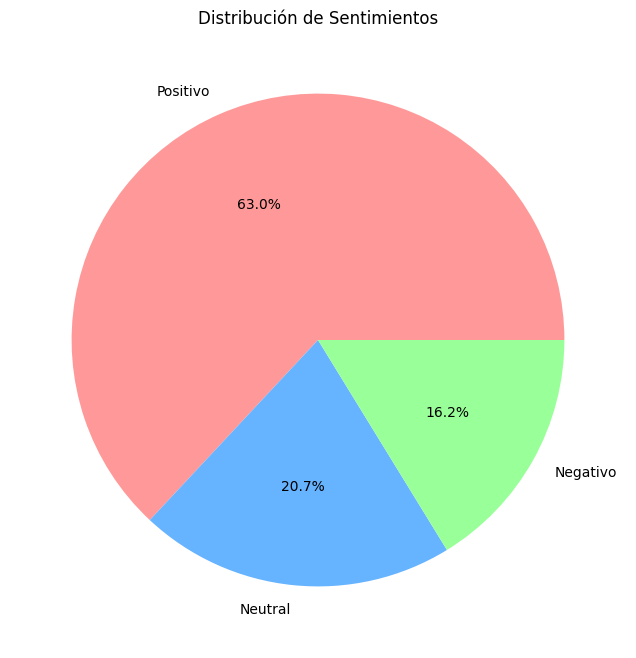

In [127]:
# Contar la frecuencia de cada categoría en la columna 'sentiment_analysis'
sentiment_counts = df_users_reviews['sentiment_analysis'].value_counts()

# Etiquetas para el gráfico
sentiment_labels = {0: 'Negativo', 1: 'Neutral', 2: 'Positivo'}
labels = [sentiment_labels[sentiment] for sentiment in sentiment_counts.index]

# Crear el gráfico de pastel
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=labels, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Distribución de Sentimientos')
plt.show()


### Gráfico de Línea de Tiempo de Sentimiento:

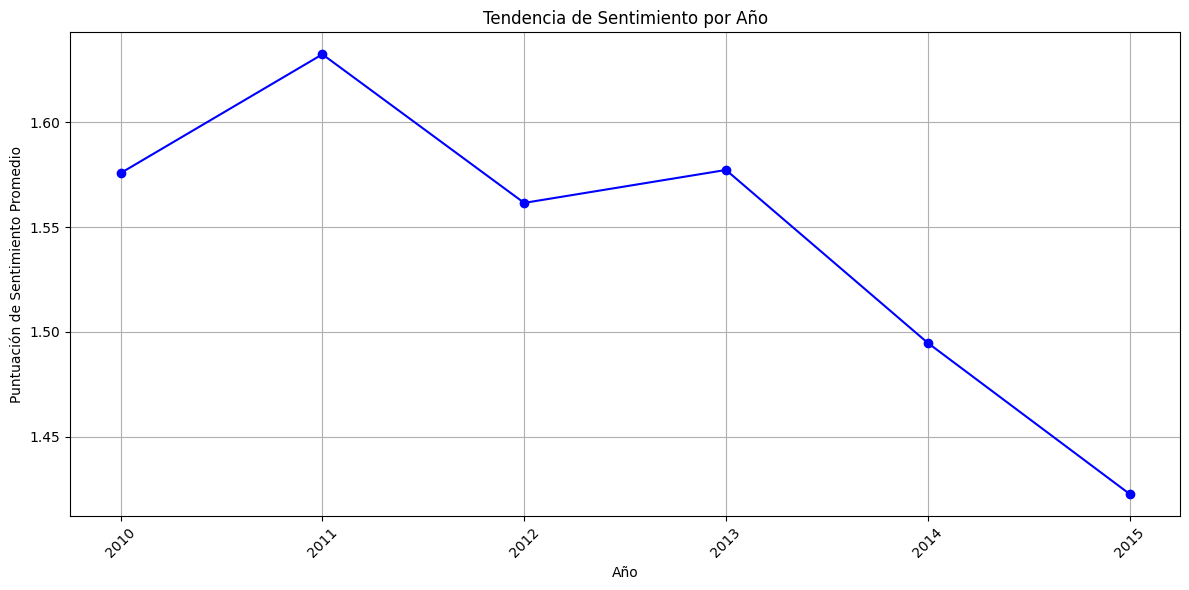

In [128]:
# Nos aseguramos de que la columna "posted" esté en formato datetime
df_users_reviews["posted"] = pd.to_datetime(df_users_reviews["posted"], errors="coerce")

# Agrupamos las reseñas por año y calculamos el promedio de sentimiento para cada año
sentiment_by_year = df_users_reviews.groupby(df_users_reviews["posted"].dt.year)["sentiment_analysis"].mean()

# Crear un gráfico de línea de tiempo por año
plt.figure(figsize=(12, 6))
sentiment_by_year.plot(kind="line", marker="o", linestyle="-", color="b")
plt.title("Tendencia de Sentimiento por Año")
plt.xlabel("Año")
plt.ylabel("Puntuación de Sentimiento Promedio")
plt.grid(True)
plt.xticks(rotation=45)  # Opcional: Rotar etiquetas del eje x si hay muchos años
plt.tight_layout()  # Ajustar el layout para que todo el contenido sea visible
plt.show()